# Find the Failed Sync Pulse Energy Fits
Refit them manually, update the fcl file

In [1]:
import ROOT as r

Welcome to JupyROOT 6.12/06


In [3]:
in_f = r.TFile('syncPulseEnergiesRun23609TQBankFits.root')

In [4]:
r.gStyle.SetOptStat(0)
r.gStyle.SetOptFit(1)

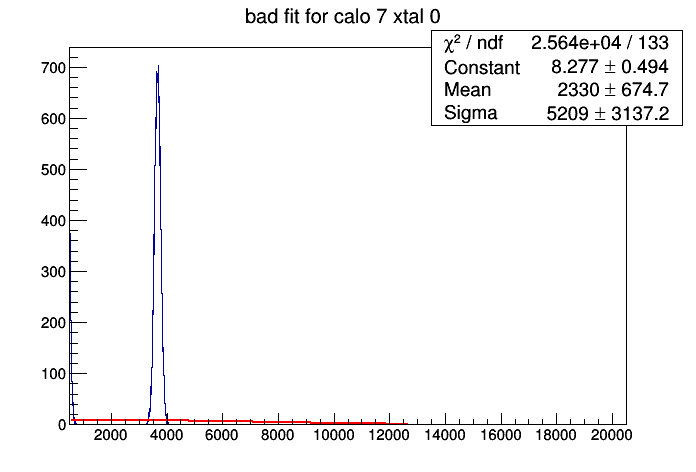

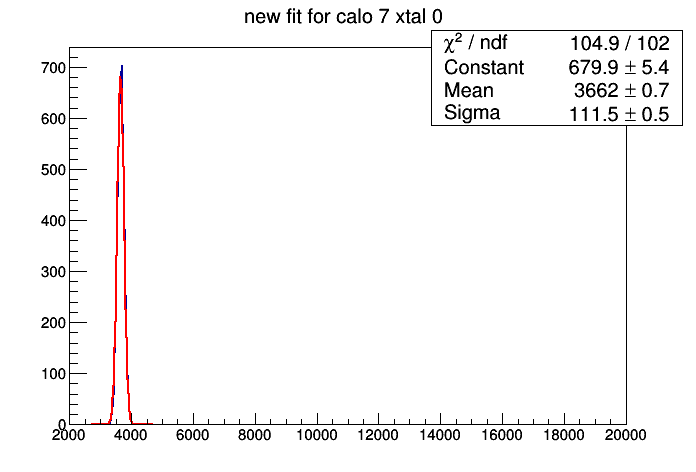

In [5]:
canvs = []
bad_hists =[]
cloned_hists = []
needed_updates = ''

# to compare with what is in the fcl file
expected_constants = []

for calo_num in range(1,25):
    for xtal_num in range(54):
        hist = in_f.Get(f'syncPulseEnergies/calo{calo_num}/calo{calo_num}xtal{xtal_num}')
        fit = hist.GetFunction('gaus')
        try:
            chi2 = fit.GetChisquare()/fit.GetNDF()
            old_val = fit.GetParameter(1)
        except ReferenceError:
            chi2 = 0
            old_val = 1
        
        if chi2 > 2.5:
            hist.SetTitle(f'bad fit for calo {calo_num} xtal {xtal_num}')
            bad_hists.append(hist)
            canvs.append(r.TCanvas())
            bad_hists[-1].Draw()
            canvs[-1].Draw()

            # refit and draw new fit
            cloned = bad_hists[-1].Clone()
            cloned.SetName(cloned.GetName() + '_cloned')
            cloned.GetXaxis().SetRangeUser(2000, 20000)
            max_bin = cloned.GetMaximumBin()
            max_x = cloned.GetBinCenter(max_bin)
        
            if cloned.GetBinContent(max_bin) > 100:
                canvs.append(r.TCanvas())
                cloned.Fit('gaus', 'q', '', max_x-1000, max_x+1000)
                cloned.GetFunction('gaus').SetLineColor(r.kRed)
                cloned.SetTitle(f'new fit for calo {calo_num} xtal {xtal_num}')
                cloned_hists.append(cloned)
                cloned_hists[-1].Draw()
                canvs[-1].Draw()
            
                new_val = cloned.GetFunction('gaus').GetParameter(1)
            
                needed_updates += f'calo {calo_num} xtal {xtal_num}:  '
                needed_updates += f'{old_val:.2f} -> {new_val:.2f}\n'
                
                expected_constants.append(f'{new_val:.2f}')
            else:
                needed_updates += f'calo {calo_num} xtal {xtal_num}:  '
                needed_updates += f'{old_val:.2f} -> ?\n'
                expected_constants.append(f'{old_val:.2f}')
     
        elif chi2 == 0:
            needed_updates += f'calo {calo_num} xtal {xtal_num}:  '
            needed_updates += f'? -> ?\n'
            expected_constants.append(f'{old_val:.2f}')

        else:
            expected_constants.append(f'{old_val:.2f}')

In [6]:
print('Needed updates:')
print(needed_updates)

Needed updates:
calo 7 xtal 0:  2330.48 -> 3662.10
calo 15 xtal 2:  ? -> ?



In [8]:
# Check the fcl file
fcl_constants = []

# load numbers from the file
with open('23609SyncEnergiesTQBankFits.fcl') as file:
    for line in file:
        words = line.split(':')
        if words[0].lstrip().startswith('xtal'):
            fcl_constants.append(f'{float(words[1].split()[0]):.2f}')
            
        
n_mismatches = 0
for expected, fcl in zip(expected_constants, fcl_constants):
    if float(expected) != float(fcl):
        n_mismatches += 1
        print(f'mismatch! {expected} != {fcl}')
                
if n_mismatches == 0:
    print('all constants match!')

all constants match!
